# ECE 276 Project 2: LiDAR based SLAM

1. load data

In [1]:
# !pip install open3d matplotlib numpy

import numpy as np
import matplotlib.pyplot as plt; plt.ion()
import time
import os
import scipy.io as sio
import open3d as o3d
import gtsam

from icp_warm_up.utils import read_canonical_model, load_pc, visualize_icp_result
import pr2_utils as U
from load_data import load_dataset


print("done")


done


encoder stamps size 4956
imu stamps size 12187


time range 1298445274.823653 to  1298445396.755451


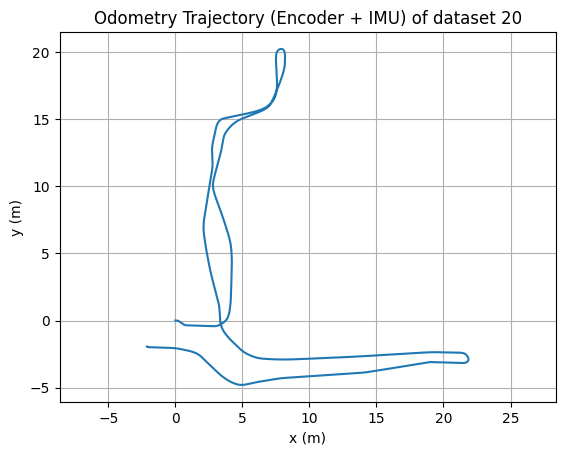

encoder stamps size 4789
imu stamps size 11730


time range 1298881995.438197 to  1298882112.795965


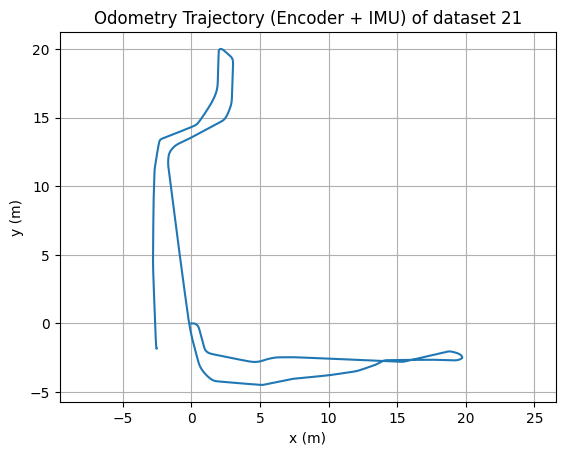

In [2]:
_ = U.encoder_IMU_odometry(20)
_ = U.encoder_IMU_odometry(21)

encoder stamps size 4956
imu stamps size 12187


time range 1298445274.823653 to  1298445396.755451


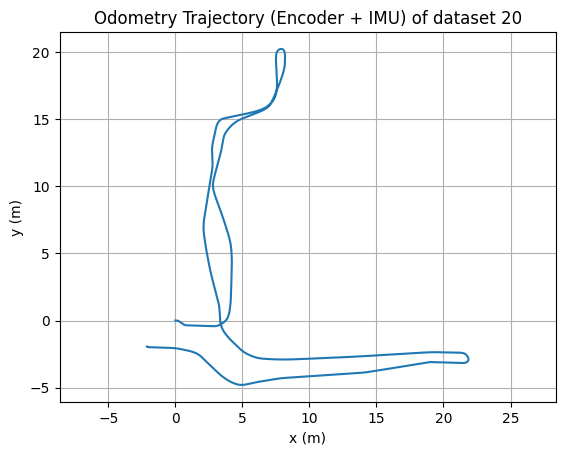

1081
lidar_ranges shape: (1081, 4962)


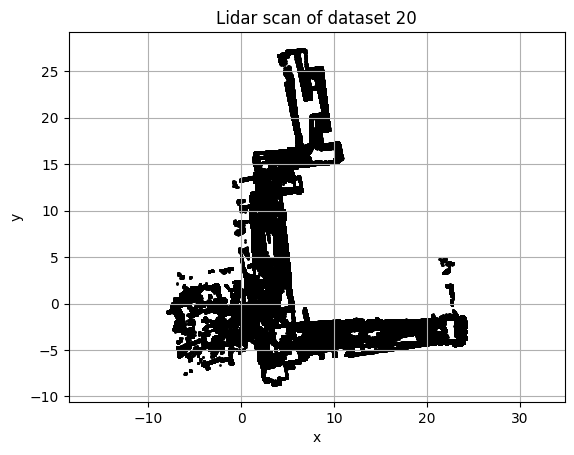

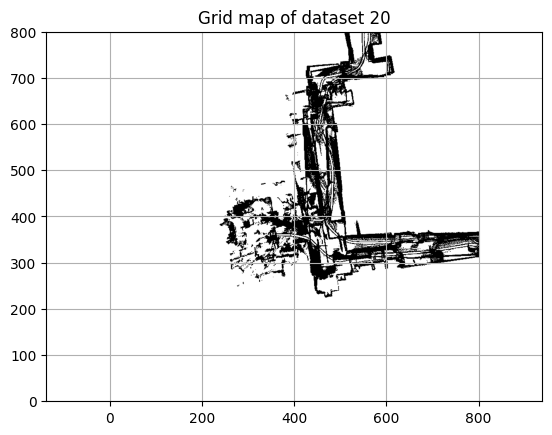

encoder stamps size 4789
imu stamps size 11730


time range 1298881995.438197 to  1298882112.795965


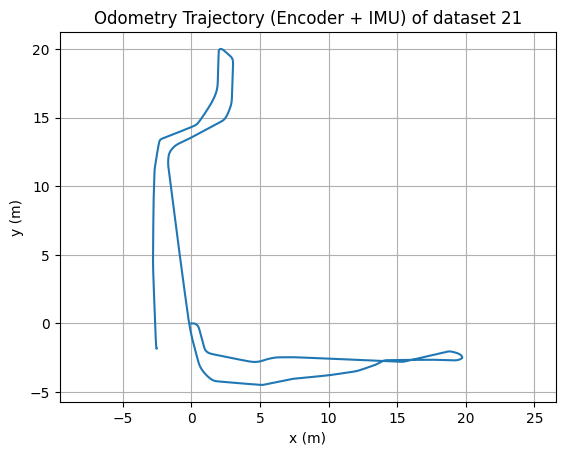

1081
lidar_ranges shape: (1081, 4785)


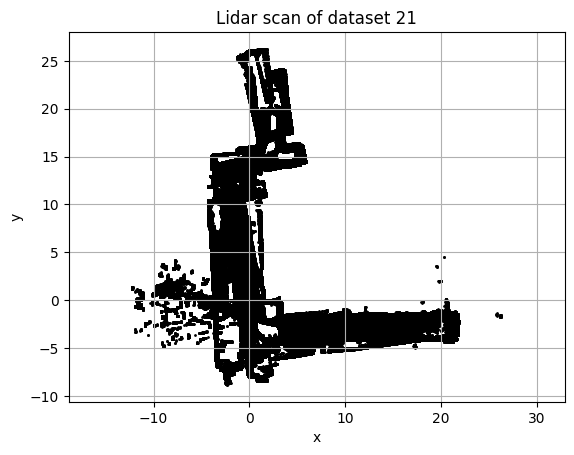

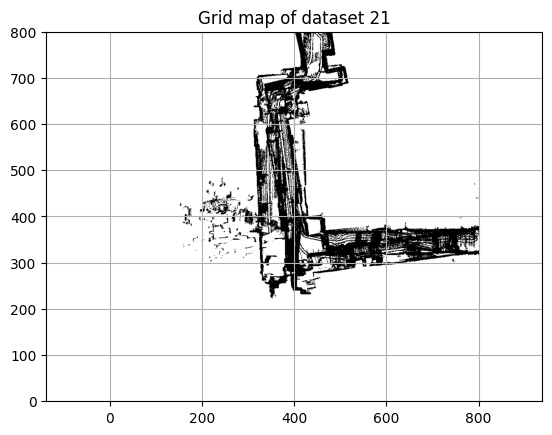

In [3]:
_ = U.test_map(dataset=20)
_ = U.test_map(dataset=21)

# 2. Point-cloud registration via iterative closest point (ICP):

In [4]:
# Warm up
source_pc, target_pc, T, info = U.warmup_icp("drill", 0, yaw_steps=36)

print("Best yaw:", info["yaw"], "Best MSE:", info["mse"])
visualize_icp_result(source_pc, target_pc, T)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/danielchen/Documents/GitHub/ECE276A_PR2/code/data/drill/model.mat'

encoder stamps size 4956
imu stamps size 12187


time range 1298445274.823653 to  1298445396.755451


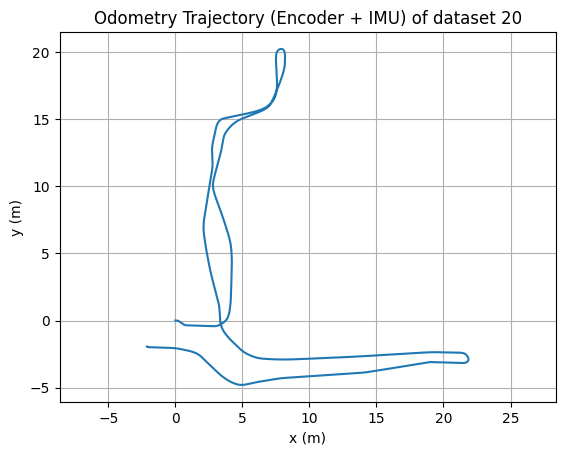

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 1081

In [ ]:
dataset = 20
encoder_data, lidar_data, imu_data, _ = load_dataset(dataset)
_, _, _, encoder_t, _, _, _, x, y, theta, _, _, _ = U.encoder_IMU_odometry(dataset)

i = 100
lidar_ranges = lidar_data["lidar_ranges"]
lidar_stamps = lidar_data["lidar_stamps"]
angle_min = lidar_data["lidar_angle_min"]
angle_increment = lidar_data["lidar_angle_increment"]
range_min = lidar_data["lidar_range_min"]
range_max = lidar_data["lidar_range_max"]

n_rays = lidar_ranges.shape[0]
angles = angle_min + np.arange(n_rays) * angle_increment

Q = U.lidar_scan_to_points(lidar_ranges[:, i], angles, range_min, range_max)
P = U.lidar_scan_to_points(lidar_ranges[:, i+1], angles, range_min, range_max)

j0 = np.argmin(np.abs(encoder_t - lidar_stamps[i]))
j1 = np.argmin(np.abs(encoder_t - lidar_stamps[i+1]))
dx, dy = x[j1]-x[j0], y[j1]-y[j0]
dtheta = theta[j1]-theta[j0]

R_init = U.rotation2d(dtheta)
p_init = np.array([[dx],[dy]])

R_icp, p_icp, mse = U.ICP(P, Q, R_init, p_init)
print("mse:", mse)

In [ ]:
# Warm Up - ICP using Kabsch
dataset = 20
U.plot_icp_alignment(P, Q, title="Before ICP (no transform)")

R_icp, p_icp, mse = U.ICP_2D(P, Q, R_init, p_init)
U.plot_icp_alignment(P, Q, R_icp, p_icp, title=f"After ICP (mse={mse:.4f})")

NameError: name 'U' is not defined